In [1]:
# MOUNTING GOOGLE DRIVE ##########################################################################

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Finetuning mobilenet model 
### The objective in this file is to use the previously trained mobilenet model (mobilenet_tuning.27-0.9527.h5), and finetune it to improve accuracy

In [ ]:
# IMPORTS LIBRARIES NEEDED #######################################################################

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam, SGD
from keras import layers
from keras import models

from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

from keras.callbacks import ModelCheckpoint, EarlyStopping

In [0]:
# DEFINES SOME PARAMETERS ########################################################################

train_path  = "/content/drive/My Drive/ML/projects/chest_xray/images/train"
test_path   = "/content/drive/My Drive/ML/projects/chest_xray/images/test"
val_path    = "/content/drive/My Drive/ML/projects/chest_xray/images/val"
models_path = "/content/drive/My Drive/ML/projects/chest_xray/cnn_models/"

# This is a mobilenet model previously trained with the same data
model_file_name ="mobilenet_tuning.27-0.9527.h5"

BATCH_SIZE = 32

IM_HEIGHT = 200
IM_WIDTH = 200

NTRAIN_IMAGES = 5216
NTEST_IMAGES = 624
NVAL_IMAGES = 16

In [4]:
# CREATES DATA GENERATORS FOR READING AND AUGMENTING IMAGES ######################################

# The train generator will rotate, shift verticaly and horizontaly, zoom, shrink, 
# and flip images horizontally
train_datagen = ImageDataGenerator(
                                   preprocessing_function = preprocess_input,
                                   rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rescale = 1./255                           )

test_datagen = ImageDataGenerator(
                                   preprocessing_function = preprocess_input,
                                   rescale = 1./255                           )

train_generator = train_datagen.flow_from_directory(train_path,
                                           target_size = (IM_HEIGHT, IM_WIDTH),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           class_mode = 'categorical')

test_generator  = test_datagen.flow_from_directory( test_path,
                                           target_size = (IM_HEIGHT, IM_WIDTH),
                                           batch_size = BATCH_SIZE,
                                           class_mode = 'categorical')

val_generator   = test_datagen.flow_from_directory( val_path,
                                           target_size=(IM_HEIGHT, IM_WIDTH),
                                           batch_size=1,
                                           class_mode='categorical')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [9]:
# LOADS THE PREVIOUSLY SAVED MODEL ##############################################################

model = models.load_model(models_path + model_file_name)

# Lets use a small learning rate to fine tune the model
optim = SGD(lr=0.00002) 
#optim = RMSprop(lr=0.0007) 
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'] )

model.summary()

# Prints full model layers
#for i,layer in enumerate(model.layers):  
#  if(layer.trainable == True): print(i,layer.name)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 201, 201, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 100, 100, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 100, 100, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 100, 100, 32)      128 

In [6]:
# TRAINS THE MODEL ###############################################################################

# Configures callback function for saving the model when val_acc improves
h5_filepath = models_path + "mobilenet_tuning.{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint( h5_filepath, monitor='val_accuracy', verbose=1, 
                              save_best_only=True, 
                              save_weights_only=False, 
                              mode='auto', 
                              period=1)  # number of epochs between checkpoints

# Configures callback to stop training when val_acc stops improving
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, 
#                       mode='auto')
#callbacks_list = [checkpoint, early]
callbacks_list = [checkpoint]

history = model.fit_generator(train_generator,
                              steps_per_epoch = NTRAIN_IMAGES // BATCH_SIZE,
                              epochs = 30,
                              validation_data = test_generator,
                              validation_steps = NTEST_IMAGES // BATCH_SIZE,
                              #shuffle = True, 
                              callbacks = callbacks_list )

Epoch 1/30
163/163 [==============================] - 1543s 9s/step - loss: 0.0075 - acc: 0.9971 - val_loss: 0.4453 - val_acc: 0.9342

Epoch 00001: val_acc improved from -inf to 0.93421, saving model to /content/drive/My Drive/ML/projects/chest_xray/cnn_models/mobilenet_tuning.01-0.9342.h5
Epoch 2/30
163/163 [==============================] - 111s 678ms/step - loss: 0.0057 - acc: 0.9977 - val_loss: 0.4573 - val_acc: 0.9341

Epoch 00002: val_acc did not improve from 0.93421
Epoch 3/30
163/163 [==============================] - 110s 676ms/step - loss: 0.0070 - acc: 0.9977 - val_loss: 0.4211 - val_acc: 0.9392

Epoch 00003: val_acc improved from 0.93421 to 0.93919, saving model to /content/drive/My Drive/ML/projects/chest_xray/cnn_models/mobilenet_tuning.03-0.9392.h5
Epoch 4/30
163/163 [==============================] - 110s 677ms/step - loss: 0.0065 - acc: 0.9977 - val_loss: 0.3756 - val_acc: 0.9426

Epoch 00004: val_acc improved from 0.93919 to 0.94257, saving model to /content/drive/My 

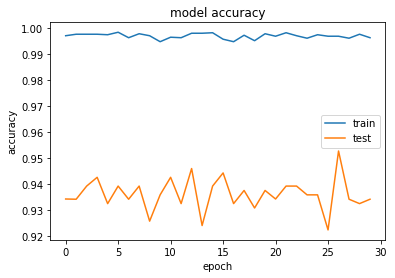

In [7]:
# PLOTS TRAINING RESULTS ###############################################################################

# Plots history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

#from sklearn.metrics import classification_report
#pred = model.predict(test_set)
#print(classification_report(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1)))

In [0]:
model_path = "/content/drive/My Drive/ML/projects/chest_xray/cnn_models/mobilenet.27-0.9527.h5"

model.save_weights(model_path)
